In [1]:

import matplotlib.pyplot as plt
import numpy as np
import xlrd
from arch.bootstrap import SPA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model


In [2]:
# read the data from the csv file /home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv

df = pd.read_csv('/home/vishi/bolinger/22-05cumul_ohlc_diff_percent.csv', index_col=0, parse_dates=True)
df.head()

,open,high,low,close,close_diff_percent,close_moving_avg,std,upper_bb,lower_bb,close_diff,close_scaled_down
DateTime,,,,,,,,,,,
2024-12-31 09:16:00,2355950,2356430,2354005,2355135,NaN,NaN,NaN,NaN,NaN,NaN,2355.135
2024-12-31 09:17:00,2355070,2356150,2354500,2355915,3.311912,NaN,NaN,NaN,NaN,780.0,2355.915
2024-12-31 09:18:00,2355980,2356025,2355100,2355405,-2.164764,NaN,NaN,NaN,NaN,-510.0,2355.405
2024-12-31 09:19:00,2355400,2357195,2355215,2356905,6.368332,NaN,NaN,NaN,NaN,1500.0,2356.905
2024-12-31 09:20:00,2356960,2357015,2355475,2355475,-6.067279,NaN,NaN,NaN,NaN,-1430.0,2355.475


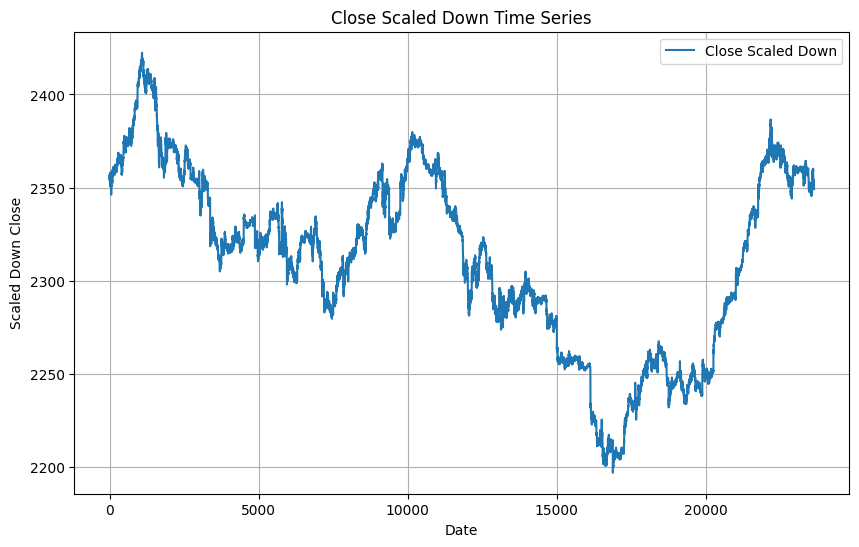

In [3]:
close_scaled_down = df['close_scaled_down']
close_scaled_down = close_scaled_down.dropna()
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(np.array(close_scaled_down), label='Close Scaled Down')
plt.title('Close Scaled Down Time Series')
plt.xlabel('Date')
plt.ylabel('Scaled Down Close')
plt.legend()
plt.grid()
plt.show()


In [4]:
# ===============================================================================================
def func_of_arima_1_1_1(t_1_data, t_2_data, ar_param, ma_param, prev_residual):
    """
    Calculate the ARIMA(1,1,1) value based on previous data and parameters.
    
    :param t_1_data: Previous time series data point (t-1)
    :param t_2_data: Previous time series data point (t-2)
    :param ar_param: AR parameter
    :param ma_param: MA parameter
    :param prev_residual: Previous residual
    :return: Computed value for the current time step
    """
    return ar_param * (t_1_data - t_2_data) + ma_param * prev_residual + t_1_data

def func_of_garch_1_1(omega, alpha, beta, prev_volatility, prev_residual):
    """
    Calculate the GARCH(1,1) value based on previous volatility and residuals.
    :param omega: Constant term
    :param alpha: Coefficient for lagged squared residuals
    :param beta: Coefficient for lagged volatility
    :param prev_volatility: Previous volatility
    :param prev_residual: Previous residual
    :return: Computed volatility for the current time step
    """
    return np.sqrt(omega + alpha * prev_residual ** 2 + beta * prev_volatility**2)

def forecast_closing_prices(df,steps=375, k = 2, startdate = "2024-12-31", end_date = "2025-02-01",
                            order_arima=(1, 1, 1), order_garch=(1, 1) ):
    df_filtered = df.loc[startdate:end_date]
    df_prediction = df.loc[df.index > end_date]


    arima_model = ARIMA(df_filtered['close_scaled_down'], order=order_arima)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        arima_fit = arima_model.fit()
    residual_np = np.array(arima_fit.resid)
    

    garch_model = arch_model(residual_np, vol='Garch', p=order_garch[0], q=order_garch[1])
    garch_fit = garch_model.fit(disp="off")

    ma_param = arima_fit.maparams[0]
    ar_param = arima_fit.arparams[0]

    prediction_arima = []
    residual_prediction = []    

    prediction_arima.append(func_of_arima_1_1_1(
        df_filtered['close_scaled_down'].iloc[-1],
        df_filtered['close_scaled_down'].iloc[-2],
        ar_param,
        ma_param,
        residual_np[-1]
    ))

    residual_prediction.append(df_prediction['close_scaled_down'][0] - prediction_arima[-1])

    prediction_arima.append(func_of_arima_1_1_1(
        prediction_arima[-1],
        df_filtered['close_scaled_down'].iloc[-1],
        ar_param,
        ma_param,
        residual_prediction[-1]
    ))
    residual_prediction.append(df_prediction['close_scaled_down'][1] - prediction_arima[-1])
    for i in range(2, steps):
        prediction_arima.append(func_of_arima_1_1_1(
            prediction_arima[-1],
            prediction_arima[-2],
            ar_param,
            ma_param,
            residual_prediction[-1]
        ))
        residual_prediction.append(df_prediction['close_scaled_down'][i] - prediction_arima[-1])

    garch_params = garch_fit.params
    omega = garch_params['omega']
    alpha = garch_params['alpha[1]']
    beta = garch_params['beta[1]']

    vol_garch = garch_fit.conditional_volatility
    volatility_prediction = []

    volatility_prediction.append(func_of_garch_1_1(
        omega,
        alpha,
        beta,
        vol_garch[-1],
        residual_np[-1]
    ))

    for i in range(1, steps):
        volatility_prediction.append(func_of_garch_1_1(
            omega,
            alpha,
            beta,
            volatility_prediction[-1],
            residual_prediction[i-1]
        ))

    return arima_fit, garch_fit, prediction_arima, residual_prediction, volatility_prediction

    

/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vishi/bolinger/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/tmp/ipykernel_130288/4245532521.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

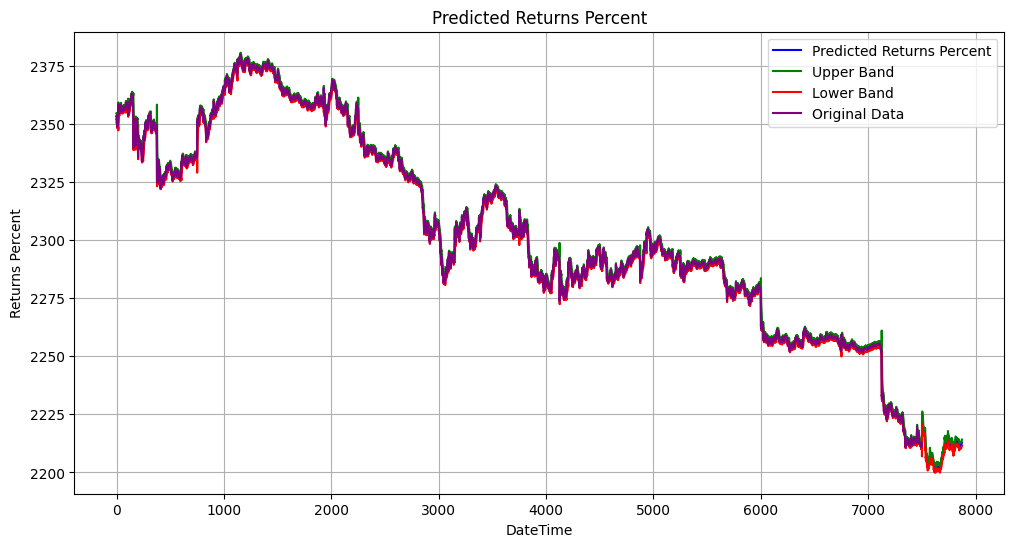

In [18]:
arima_fit_forecast, garch_fit_forecast, prediction_arima, residual_prediction, volatility_prediction = forecast_closing_prices(
    df, steps=7875, startdate="2024-12-31", end_date="2025-02-01 09:00",
    order_arima=(1, 1, 1), order_garch=(1, 1)
)
upper_band = np.array(prediction_arima) + 1.5 * np.array(volatility_prediction)
lower_band = np.array(prediction_arima) - 1.5 * np.array(volatility_prediction)
mid_band = np.array(prediction_arima)


plt.figure(figsize=(12, 6))
plt.plot(mid_band, label='Predicted Returns Percent', color='blue')
plt.plot(upper_band, label='Upper Band', color='green')
plt.plot(lower_band, label='Lower Band', color='red')
# plt.plot(resid_pred_xyz, label='Residuals of Predicted Returns Percent', color='orange')
plt.plot(np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-02-28 23:00']), label='Original Data', color='purple')
plt.title('Predicted Returns Percent')
plt.xlabel('DateTime')
plt.ylabel('Returns Percent')
plt.legend()
plt.grid()
plt.show()

In [19]:

def get_avg_std(prices:np.ndarray,period:int)->tuple:
    '''
        Takes a numpy array of prices and gives the moving average 
        and std deviation of the prices \\
        **********
        #### INPUT
        prices - a numpy array of prices \\
        period - a int, the period for which the moving 
                average and std deviation is to be calculated
        **********
        #### OUTPUT
        tuple - a tuple of the moving average and std deviation
        of the prices
                '''
    avg = np.zeros(len(prices))
    std = np.zeros(len(prices))
    for i in range(period, len(prices)+1):
        avg[i-1] = np.mean(prices[i-period:i])
        std[i-1] = np.std(prices[i-period:i])
    return avg, std
    
def construct_upper_lower_bands(prices:np.ndarray, moving_avg:np.ndarray, moving_std:np.ndarray, period:int)->tuple:
    '''
        Takes a numpy array of prices and gives the upper and lower bands \\
        **********
        #### INPUT
        prices - a numpy array of prices \\
        moving_avg - a numpy array of moving averages \\
        moving_std - a numpy array of std deviations \\
        period - a int, the period for which the moving 
                average and std deviation is to be calculated
        **********
        #### OUTPUT
        tuple - a tuple of the upper and lower bands
    '''
    upper_band = np.zeros(len(prices))
    lower_band = np.zeros(len(prices))
    for i in range(period, len(prices)+1):
        upper_band[i-1] = moving_avg[i-1] + 2*moving_std[i-1]
        lower_band[i-1] = moving_avg[i-1] - 2*moving_std[i-1]
    return upper_band, lower_band


def buy_and_sell_profits_basic(closing_prices:np.ndarray, upper_band:np.ndarray, lower_band:np.ndarray, mid_band:np.ndarray):
    '''
        Takes a numpy array of closing prices and gives the profits made by buying and selling \\
            **********
            #### INPUT
            # closing_prices - a numpy array of closing prices \\
            # upper_band - a numpy array of upper bands \\
            # lower_band - a numpy array of lower bands \\
            # mid_band - a numpy array of mid bands \\
            # **********
            # #### OUTPUT
            # tuple - a tuple of the profits made by buying and selling
    '''
    # flag = 0 => no position
    # flag = 1 => long position
    # flag = -1 => short position
    # current_price = the price at which the position was taken
    flag = 0
    current_price = 0
    list_of_profit = []
    profit = 0

    for i in range(len(closing_prices)):
        if flag == 0:
            if closing_prices[i] > upper_band[i]:
                flag = 0
                current_price = closing_prices[i]
            elif closing_prices[i] < lower_band[i]:
                flag = 1
                current_price = closing_prices[i]
        elif flag == -1:
            if closing_prices[i] < mid_band[i]:
                flag = 0
                profit += current_price - closing_prices[i]
        elif flag == 1:
            if closing_prices[i] > mid_band[i]:
                flag = 0
                profit += closing_prices[i] - current_price
        list_of_profit.append(profit)
    if flag == -1:
        profit += current_price - closing_prices[-1]
    elif flag == 1:
        profit += closing_prices[-1] - current_price
    list_of_profit.append(profit)
    return list_of_profit


def generate_list_of_profit(closing_prices:np.ndarray, period:int = 20, k:int = 2):
    '''
        Takes a numpy array of closing prices and gives the profits made by buying and selling \\
            **********
            #### INPUT
            # closing_prices - a numpy array of closing prices \\
            # period - a int, the period for which the moving 
                    average and std deviation is to be calculated
            # k - a int, the number of standard deviations to be used
            **********
            # #### OUTPUT
            # tuple - a tuple of the profits made by buying and selling
    '''
    moving_avg, moving_std = get_avg_std(closing_prices, period=period)
    upper_band, lower_band = construct_upper_lower_bands(closing_prices, moving_avg, moving_std, period=period)
    list_of_profit = buy_and_sell_profits_basic(closing_prices, upper_band, lower_band, moving_avg)
    return list_of_profit


In [20]:

list_of_periods = [5, 10, 15, 20, 25, 30]
list_of_k = [1, 1.5, 2]

closing_prices = np.array(df['close_scaled_down'].loc['2025-02-01 09:00' : '2025-02-28 23:00'])

list_of_profits = []
for k in list_of_k:
    for period in list_of_periods:
        list_of_profits.append(generate_list_of_profit(closing_prices, period, k))
        print(f"Profit for period {period} and k {k} is completed")


Profit for period 5 and k 1 is completed
Profit for period 10 and k 1 is completed
Profit for period 15 and k 1 is completed
Profit for period 20 and k 1 is completed
Profit for period 25 and k 1 is completed
Profit for period 30 and k 1 is completed
Profit for period 5 and k 1.5 is completed
Profit for period 10 and k 1.5 is completed
Profit for period 15 and k 1.5 is completed
Profit for period 20 and k 1.5 is completed
Profit for period 25 and k 1.5 is completed
Profit for period 30 and k 1.5 is completed
Profit for period 5 and k 2 is completed
Profit for period 10 and k 2 is completed
Profit for period 15 and k 2 is completed
Profit for period 20 and k 2 is completed
Profit for period 25 and k 2 is completed
Profit for period 30 and k 2 is completed


In [21]:
benchmark_profit = buy_and_sell_profits_basic(closing_prices, upper_band, lower_band, mid_band)


list_of_returns = []
for i in range(len(list_of_profits)):
    list_of_returns.append(np.diff(list_of_profits[i]))

benchmark_returns = np.diff(benchmark_profit) * 1000
list_of_returns = np.array(list_of_returns).T

benchmark_losses = -benchmark_returns
strategy_losses = -list_of_returns

spa = SPA(benchmark=benchmark_losses,
          models=strategy_losses,
          reps=1000,
          block_size=100,  
          bootstrap="stationary",
          studentize=True,
          nested=False,
          seed=42
          )
spa.compute()
result = spa.better_models(pvalue=0.05, pvalue_type="consistent")
result

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [22]:
def reverse_of_buy_and_sell_profits_basic(closing_prices:np.ndarray, upper_band:np.ndarray, lower_band:np.ndarray, mid_band:np.ndarray):
    '''
        Takes a numpy array of closing prices and gives the profits made by buying and selling \\
            **********
            #### INPUT
            # closing_prices - a numpy array of closing prices \\
            # upper_band - a numpy array of upper bands \\
            # lower_band - a numpy array of lower bands \\
            # mid_band - a numpy array of mid bands \\
            # **********
            # #### OUTPUT
            # tuple - a tuple of the profits made by buying and selling
    '''
    # flag = 0 => no position
    # flag = 1 => long position
    # flag = -1 => short position
    # current_price = the price at which the position was taken
    flag = 0
    current_price = 0
    list_of_profit = []
    profit = 0

    for i in range(len(closing_prices)):
        if flag == 0:
            if closing_prices[i] < lower_band[i]:
                flag = -1
                current_price = closing_prices[i]
            elif closing_prices[i] > upper_band[i]:
                flag = 1
                current_price = closing_prices[i]
        elif flag == -1:
            if closing_prices[i] > mid_band[i]:
                flag = 0
                profit += current_price - closing_prices[i]
        elif flag == 1:
            if closing_prices[i] < mid_band[i]:
                flag = 0
                profit += closing_prices[i] - current_price
        list_of_profit.append(profit)
    if flag == -1:
        profit += current_price - closing_prices[-1]
    elif flag == 1:
        profit += closing_prices[-1] - current_price
    list_of_profit.append(profit)
    return list_of_profit



In [23]:
benchmark_profit_2 = reverse_of_buy_and_sell_profits_basic(closing_prices, upper_band, lower_band, mid_band)

benchmark_returns_2 = np.diff(benchmark_profit_2) *1000
benchmark_losses_2 = -benchmark_returns_2

spa_2 = SPA(benchmark=benchmark_losses_2,
            models=strategy_losses,
            reps=1000,
            block_size=100,  
            bootstrap="stationary",
            studentize=True,
            nested=False,
            seed=42
            )
spa_2.compute()
result_2 = spa_2.better_models(pvalue=0.05, pvalue_type="consistent")
print("Results of the SPA test with original buy and sell strategy:")
print(result)
print("Results of the SPA test with reversed buy and sell strategy:")
print(result_2)


Results of the SPA test with original buy and sell strategy:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Results of the SPA test with reversed buy and sell strategy:
[]


In [24]:
print(benchmark_profit_2[-1])
print(benchmark_profit[-1])

23.144999999998163
-74.71499999999651


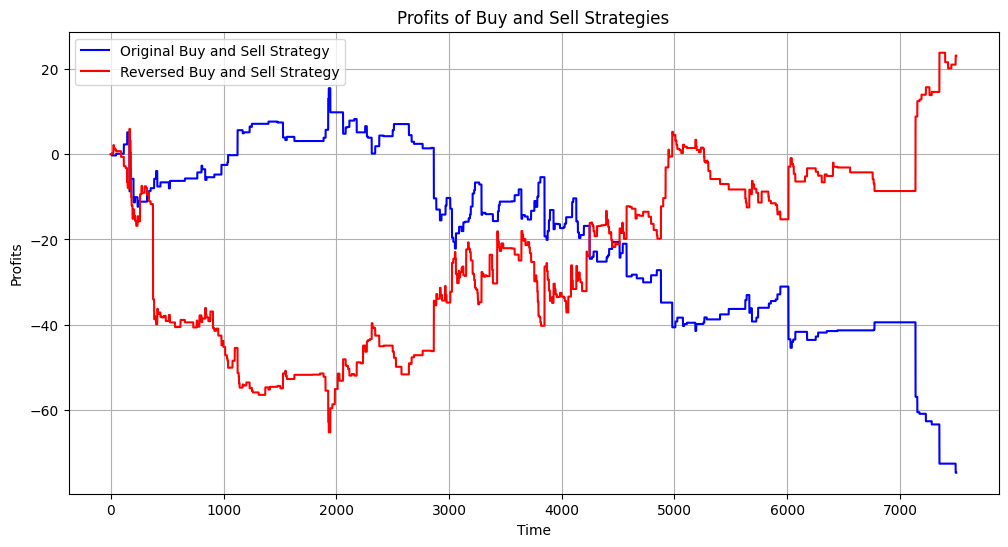

In [25]:
# plotprofits 1 and 2
plt.figure(figsize=(12, 6))
plt.plot(benchmark_profit, label='Original Buy and Sell Strategy', color='blue')
plt.plot(benchmark_profit_2, label='Reversed Buy and Sell Strategy', color='red')
plt.title('Profits of Buy and Sell Strategies')
plt.xlabel('Time')
plt.ylabel('Profits')
plt.legend()
plt.grid()
plt.show()


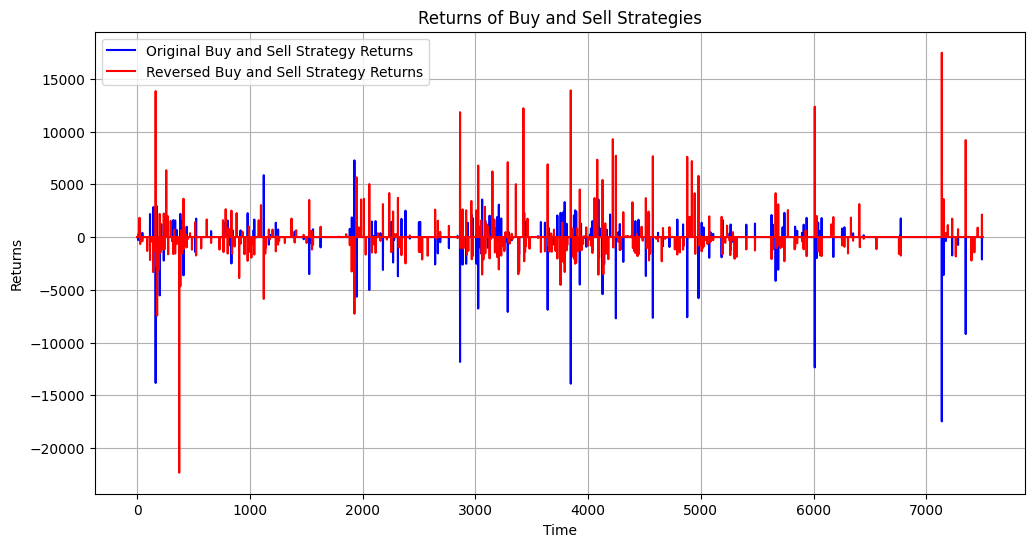

In [26]:
returns_1 = np.diff(benchmark_profit) * 1000
returns_2 = np.diff(benchmark_profit_2) * 1000
plt.figure(figsize=(12, 6))
plt.plot(returns_1, label='Original Buy and Sell Strategy Returns', color='blue')
plt.plot(returns_2, label='Reversed Buy and Sell Strategy Returns', color='red')
plt.title('Returns of Buy and Sell Strategies')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()


In [14]:
import random
from scipy import stats

def sample_mins(lenght):
    # sample randome ints in range of 0 to lenght
    list_of_mins = []
    for i in range(300):
        rand = random.randint(0, lenght-1)
        list_of_mins.append(rand)
    return list_of_mins


def hypothesis_test(reshaped_list_of_profits_i,reshaped_list_of_profits_j, list_of_mins):
    
    t_stat, p_value = stats.ttest_ind(reshaped_list_of_profits_i, reshaped_list_of_profits_j,equal_var=False)
    if p_value < 0.05:
        if np.mean(reshaped_list_of_profits_i) > np.mean(reshaped_list_of_profits_j):
            return "a better model"
        else:
            return "a worse model"
    else:
        return "no significant difference between the models"

list_of_mins = sample_mins(len(benchmark_profit))

hypothesis_test(    np.array(benchmark_profit)[list_of_mins],
    np.array(benchmark_profit_2)[list_of_mins],
    list_of_mins
)

    
    

'a worse model'

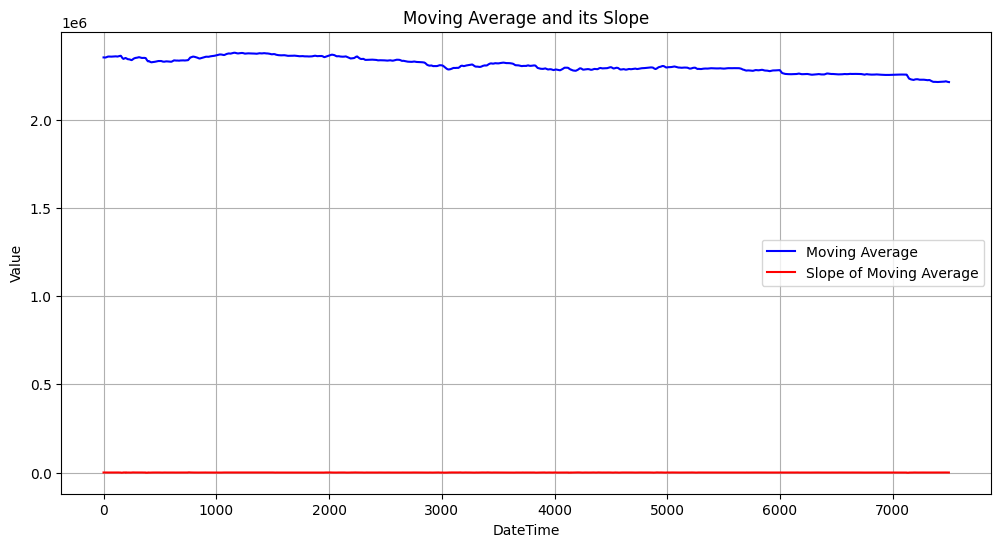

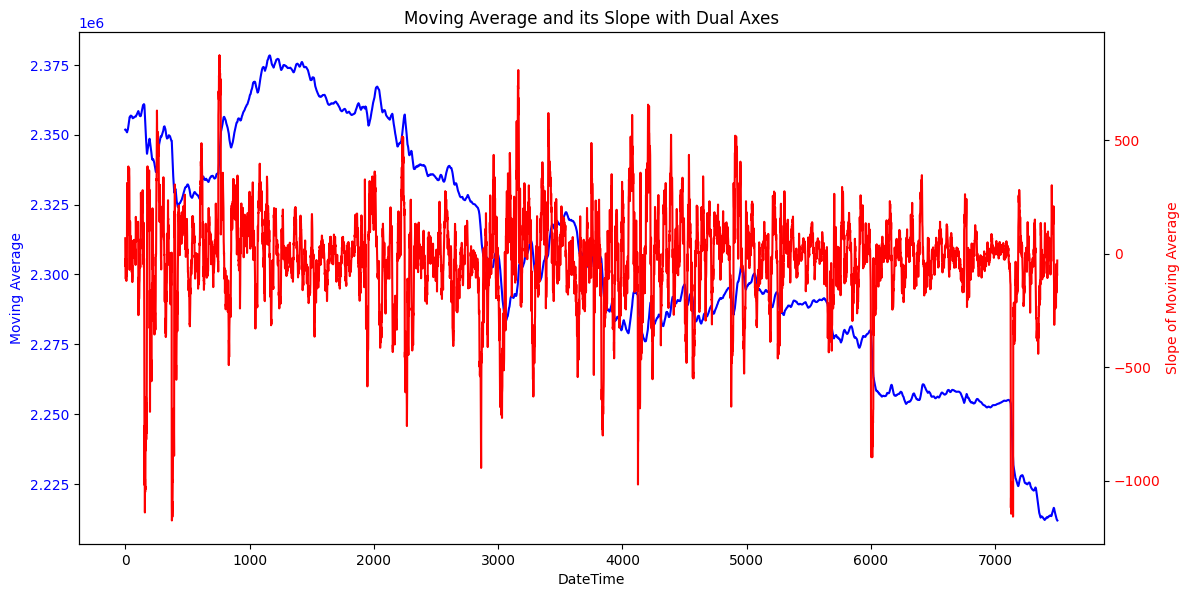

(7500, 7499, 7500, 7500)

In [15]:
moving_avg = np.array(df['close_moving_avg'].loc['2025-02-01 09:00' : '2025-02-28 23:00'])
slope = np.diff(np.array(moving_avg))
plt.figure(figsize=(12, 6))
plt.plot(moving_avg, label='Moving Average', color='blue')
plt.plot(slope, label='Slope of Moving Average', color='red')
plt.title('Moving Average and its Slope')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# use dual axes to plot moving average and slope of moving average
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(moving_avg, label='Moving Average', color='blue')
ax1.set_xlabel('DateTime')
ax1.set_ylabel('Moving Average', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(slope, label='Slope of Moving Average', color='red')

ax2.set_ylabel('Slope of Moving Average', color='red')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Moving Average and its Slope with Dual Axes')
plt.show()
# Calculate the correlation between the moving average and its slope
len(moving_avg), len(slope),len(returns_1), len(returns_2)

In [16]:
# corelate the slope and the returns
correlation_slope_returns_1 = np.corrcoef(slope, returns_1[:len(slope)])[0, 1]
correlation_slope_returns_2 = np.corrcoef(slope, returns_2[:len(slope)])[0, 1]
print(f"Correlation between slope of moving average and returns of original buy and sell strategy: {correlation_slope_returns_1}")
print(f"Correlation between slope of moving average and returns of reversed buy and sell strategy: {correlation_slope_returns_2}")

Correlation between slope of moving average and returns of original buy and sell strategy: 0.10925219030327801
Correlation between slope of moving average and returns of reversed buy and sell strategy: -0.07519920998203827


In [17]:
return_to_compare_1 = returns_1[:len(slope)]
return_to_compare_2 = returns_2[:len(slope)]

# indices of non zero values in return_to_compare_1 and return_to_compare_2
non_zero_indices_1 = np.nonzero(return_to_compare_1)[0]
non_zero_indices_2 = np.nonzero(return_to_compare_2)[0]
# Calculate the correlation between the slope and the returns
correlation_slope_returns_1_non_zero = np.corrcoef(slope[non_zero_indices_1], return_to_compare_1[non_zero_indices_1])[0, 1]
correlation_slope_returns_2_non_zero = np.corrcoef(slope[non_zero_indices_2], return_to_compare_2[non_zero_indices_2])[0, 1]
print(f"Correlation between slope of moving average and returns of original buy and sell strategy (non-zero): {correlation_slope_returns_1_non_zero}")
print(f"Correlation between slope of moving average and returns of reversed buy and sell strategy (non-zero): {correlation_slope_returns_2_non_zero}")


Correlation between slope of moving average and returns of original buy and sell strategy (non-zero): 0.7239241602679466
Correlation between slope of moving average and returns of reversed buy and sell strategy (non-zero): -0.34283720329066175
